## Librerias

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
from functools import reduce
from collections import Counter
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import networkx as nx
import igraph as ig
from networkx.algorithms import community
from networkx.algorithms.community.quality import modularity
import jinja2

## Lectura de datos

In [3]:
df_1200_1400= pd.read_csv("../data/processed/chess_data_1200-1400_full.csv")
df_1400_1600= pd.read_csv("../data/processed/chess_data_1400-1600_full.csv")
df_1600_1800= pd.read_csv("../data/processed/chess_data_1600-1800_full.csv")

## Analisis exploratorio de los datos

In [4]:
## Quedaron columnas con nulos?
def print_null_counts(df, nombre_df):
    print(f"\nEn {nombre_df}:")
    for col in df.columns:
        nulos = df[col].isnull().sum()
        no_nulos = df[col].notnull().sum()
        print(f"Columna '{col}': nulos = {nulos}, no nulos = {no_nulos}")

print_null_counts(df_1200_1400, "df_1200_1400")
print_null_counts(df_1400_1600, "df_1400_1600")
print_null_counts(df_1600_1800, "df_1600_1800")



En df_1200_1400:
Columna 'game_id': nulos = 0, no nulos = 345739
Columna 'white_player': nulos = 0, no nulos = 345739
Columna 'black_player': nulos = 0, no nulos = 345739
Columna 'white_elo': nulos = 0, no nulos = 345739
Columna 'black_elo': nulos = 0, no nulos = 345739
Columna 'elo_group': nulos = 0, no nulos = 345739
Columna 'opening': nulos = 0, no nulos = 345739
Columna 'eco': nulos = 0, no nulos = 345739
Columna 'time_control': nulos = 0, no nulos = 345739
Columna 'tipo_de_partida': nulos = 0, no nulos = 345739
Columna 'opening_sequence': nulos = 256, no nulos = 345483
Columna 'file_tag': nulos = 0, no nulos = 345739

En df_1400_1600:
Columna 'game_id': nulos = 0, no nulos = 468910
Columna 'white_player': nulos = 0, no nulos = 468910
Columna 'black_player': nulos = 0, no nulos = 468910
Columna 'white_elo': nulos = 0, no nulos = 468910
Columna 'black_elo': nulos = 0, no nulos = 468910
Columna 'elo_group': nulos = 0, no nulos = 468910
Columna 'opening': nulos = 0, no nulos = 468910

### Cantidad de partidas

In [5]:
#Cantidad de partidas por rango de ELO
print(f'{df_1200_1400.shape}, {df_1400_1600.shape}, {df_1600_1800.shape}')

(345739, 12), (468910, 12), (414393, 12)


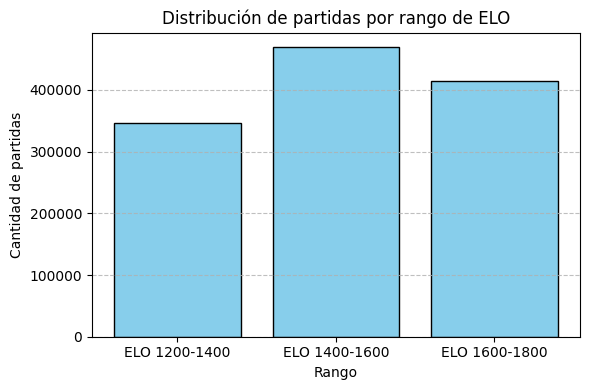

In [6]:
cantidad = [
    df_1200_1400.shape[0],
    df_1400_1600.shape[0],
    df_1600_1800.shape[0]
]

rango_elo = ['ELO 1200-1400', 'ELO 1400-1600', 'ELO 1600-1800']

plt.figure(figsize=(6, 4))
plt.bar(rango_elo, cantidad, color='skyblue', edgecolor='black')
plt.xlabel('Rango')
plt.ylabel('Cantidad de partidas')
plt.title('Distribución de partidas por rango de ELO')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

### Cantidad de jugadores distintos y cantidad de aperturas distintas en cada dataset

In [ ]:
dfs = [df_1200_1400, df_1400_1600, df_1600_1800]
rango_elo = ['ELO 1200-1400', 'ELO 1400-1600', 'ELO 1600-1800']
jugadores_distintos = []
aperturas_distintas = []

for df in dfs:
    jugadores = pd.unique(df['white_player'].tolist() + df['black_player'].tolist())
    jugadores_distintos.append(len(jugadores))
    aperturas_distintas.append(df['eco'].nunique())

for i, rango in enumerate(rango_elo):
    print(f'Rango {rango}: {jugadores_distintos[i]} jugadores distintos, {aperturas_distintas[i]} aperturas distintas')

plt.figure(figsize=(6,4))
plt.bar(rango_elo, jugadores_distintos, color='mediumseagreen', edgecolor='black')
plt.xlabel('Rango')
plt.ylabel('Cantidad de jugadores distintos')
plt.title('Cantidad de jugadores distintos por rango de ELO')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.bar(rango_elo, aperturas_distintas, color='orange', edgecolor='black')
plt.xlabel('Rango')
plt.ylabel('Cantidad de aperturas distintas')
plt.title('Cantidad de aperturas distintas por rango de ELO')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\Federico\AppData\Local\Temp\ipykernel_14700\387550472.py:7: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  jugadores = pd.unique(df['white_player'].tolist() + df['black_player'].tolist())


### Cantidad de aperturas totales

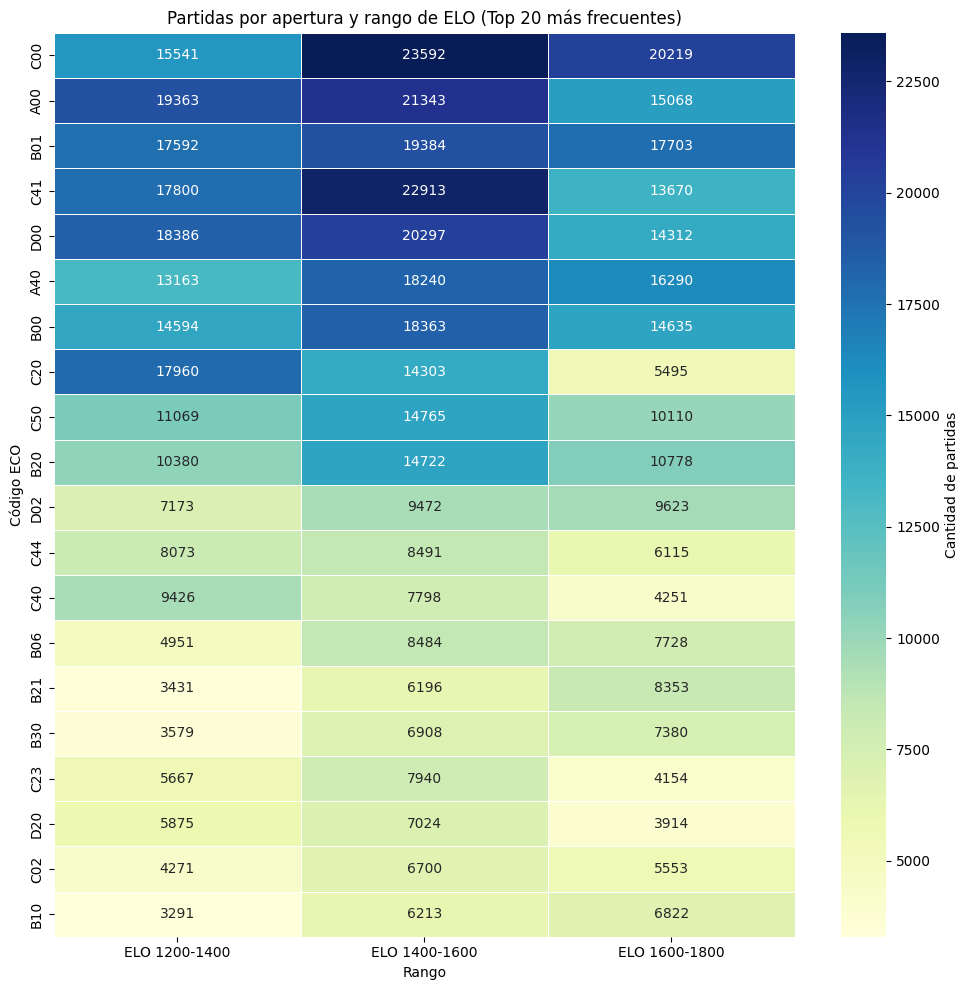

In [ ]:
def contar_aperturas(df, sufijo):
    return (
        df.groupby("eco")["game_id"]
        .nunique()
        .reset_index(name=f"cantidad_{sufijo}")
    )


dfs = [
    (df_1200_1400, "1200_1400"),
    (df_1400_1600, "1400_1600"),
    (df_1600_1800, "1600_1800")
]

cantidades = [contar_aperturas(df, sufijo) for df, sufijo in dfs]

aperturas_comunes = reduce(
    lambda izquierda, derecha: pd.merge(izquierda, derecha, on="eco", how="inner"),
    cantidades
)

columnas_cantidades = [f"cantidad_{sufijo}" for _, sufijo in dfs]
aperturas_comunes["total"] = aperturas_comunes[columnas_cantidades].sum(axis=1)

aperturas_top = aperturas_comunes.sort_values(by="total", ascending=False).head(20)

df_mapa_calor = aperturas_top.set_index("eco")[
    ["cantidad_1200_1400", "cantidad_1400_1600", "cantidad_1600_1800"]
]
df_mapa_calor.columns = ['ELO 1200-1400', 'ELO 1400-1600', 'ELO 1600-1800']
plt.figure(figsize=(10, max(6, len(df_mapa_calor) * 0.5)))
sns.heatmap(df_mapa_calor, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Cantidad de partidas"})
plt.title("Partidas por apertura y rango de ELO (Top 20 más frecuentes)")
plt.xlabel("Rango")
plt.ylabel("Código ECO")
plt.tight_layout()
plt.show()

In [ ]:
# Hay aperturas que no se pudieron clasificar en cada grupo de ELO?
dfs = [
    (df_1200_1400, "1200_1400"),
    (df_1400_1600, "1400_1600"),
    (df_1600_1800, "1600_1800")
]

for df, sufijo in dfs:
    cantidad_no_clasificadas = (df["eco"] == "?").sum()
    print(f'Cantidad de aperturas no clasificadas ("?") en el grupo {sufijo}: {cantidad_no_clasificadas}')
plt.show()

Cantidad de aperturas no clasificadas ("?") en el grupo 1200_1400: 256
Cantidad de aperturas no clasificadas ("?") en el grupo 1400_1600: 811
Cantidad de aperturas no clasificadas ("?") en el grupo 1600_1800: 733


# Resultados
## Seleccion de aperturas y jugadores, para luego analizar la cantidad de partidas

In [ ]:
# Elimino las partidas con ECO no asignado 
df_1200_1400 = df_1200_1400[df_1200_1400["eco"] != "?"]
df_1400_1600 = df_1400_1600[df_1400_1600["eco"] != "?"]
df_1600_1800 = df_1600_1800[df_1600_1800["eco"] != "?"]

## Lógica de la selección

1. **Selección de aperturas más representativas:**
   - Se cuentan cuáles son las aperturas más jugadas.
   - Se calcula el total de partidas para cada apertura.
   - Se obtiene el total acumulado de partidas por apertura y se divide por el total de partidas, normalizando estos valores para que representen proporciones. Por ejemplo, si el 70% de las partidas se acumulan en las primeras pocas aperturas, esas aperturas son las más representativas.


2. **Selección de jugadores:**
   - Se excluyen jugadores que en 3 meses hayan jugado menos de 50 partidas o más de 200 partidas.



In [ ]:
unicas_1200_1400 = df_1200_1400['eco'].nunique()
unicas_1400_1600 = df_1400_1600['eco'].nunique()
unicas_1600_1800 = df_1600_1800['eco'].nunique()

print(f'Cantidad de aperturas distintas antes de filtrar: \n Elo 1200-1400: {unicas_1200_1400} \n Elo 1400-1600: {unicas_1400_1600} \n Elo 1600-1800: {unicas_1600_1800}')

Cantidad de aperturas distintas antes de filtrar: 
 Elo 1200-1400: 365 
 Elo 1400-1600: 426 
 Elo 1600-1800: 465


In [ ]:
def aperturas_representativas(df): 
    eco_counts = df['eco'].value_counts()
    total_partidas = eco_counts.sum()
    eco_cumsum = eco_counts.cumsum() / total_partidas
    eco_70 = eco_cumsum[eco_cumsum <= 0.7].index.tolist()
    df = df[df['eco'].isin(eco_70)]
    return df

In [ ]:
df_1200_1400=aperturas_representativas(df_1200_1400)
df_1400_1600=aperturas_representativas(df_1400_1600)
df_1600_1800=aperturas_representativas(df_1600_1800)

In [ ]:
unicas_1200_1400 = df_1200_1400['eco'].nunique()
unicas_1400_1600 = df_1400_1600['eco'].nunique()
unicas_1600_1800 = df_1600_1800['eco'].nunique()

print(f'Cantidad de aperturas distintas despues de filtrar: \n Elo 1200-1400: {unicas_1200_1400} \n Elo 1400-1600: {unicas_1400_1600} \n Elo 1600-1800: {unicas_1600_1800}')

Cantidad de aperturas distintas despues de filtrar: 
 Elo 1200-1400: 26 
 Elo 1400-1600: 33 
 Elo 1600-1800: 42


In [ ]:
j_blancos_1200_1400 = df_1200_1400['white_player'].nunique()
j_negros_1200_1400 = df_1200_1400['black_player'].nunique()
jugadores_unicos_1200_1400 = j_blancos_1200_1400 + j_negros_1200_1400
j_blancos_1400_1600 = df_1400_1600['white_player'].nunique()
j_negros_1400_1600 = df_1400_1600['black_player'].nunique()
jugadores_unicos_1400_1600 = j_blancos_1400_1600 + j_negros_1400_1600
j_blancos_1600_1800 = df_1600_1800['white_player'].nunique()
j_negros_1600_1800 = df_1600_1800['black_player'].nunique()
jugadores_unicos_1600_1800 = j_blancos_1600_1800 + j_negros_1600_1800

print(f'Cantidad de jugadores distintos antes de filtrar: \n Elo 1200-1400: {jugadores_unicos_1200_1400} \n Elo 1400-1600: {jugadores_unicos_1400_1600} \n Elo 1600-1800: {jugadores_unicos_1600_1800}')


Cantidad de jugadores distintos antes de filtrar: 
 Elo 1200-1400: 54734 
 Elo 1400-1600: 67813 
 Elo 1600-1800: 51338


In [ ]:
def filtro_jugadores(df):
    # Contar partidas como blancas y negras por separado
    jugadores_blancas_counts = df['white_player'].value_counts()
    jugadores_negras_counts = df['black_player'].value_counts()
    
    # Filtrar jugadores con más de 100 y menos de 200 partidas en cada color
    jugadores_seleccionados = jugadores_blancas_counts[
        (jugadores_blancas_counts > 50) & (jugadores_blancas_counts < 300) &
        (jugadores_negras_counts > 50) & (jugadores_negras_counts < 300)
    ].index.tolist()
    # Filtrar el DataFrame original
    df = df[
        df['white_player'].isin(jugadores_seleccionados) & 
        df['black_player'].isin(jugadores_seleccionados)
    ]
    return df

In [ ]:
df_1200_1400=filtro_jugadores(df_1200_1400)
df_1400_1600=filtro_jugadores(df_1400_1600)
df_1600_1800=filtro_jugadores(df_1600_1800)

In [ ]:
j_blancos_1200_1400 = df_1200_1400['white_player'].nunique()
j_negros_1200_1400 = df_1200_1400['black_player'].nunique()
jugadores_unicos_1200_1400 = j_blancos_1200_1400 + j_negros_1200_1400

j_blancos_1400_1600 = df_1400_1600['white_player'].nunique()
j_negros_1400_1600 = df_1400_1600['black_player'].nunique()
jugadores_unicos_1400_1600 = j_blancos_1400_1600 + j_negros_1400_1600

j_blancos_1600_1800 = df_1600_1800['white_player'].nunique()
j_negros_1600_1800 = df_1600_1800['black_player'].nunique()
jugadores_unicos_1600_1800 = j_blancos_1600_1800 + j_negros_1600_1800

print(f'Cantidad de jugadores distintos despues de filtrar: \n Elo 1200-1400: {jugadores_unicos_1200_1400} \n Elo 1400-1600: {jugadores_unicos_1400_1600} \n Elo 1600-1800: {jugadores_unicos_1600_1800}')


Cantidad de jugadores distintos despues de filtrar: 
 Elo 1200-1400: 1140 
 Elo 1400-1600: 1941 
 Elo 1600-1800: 1848


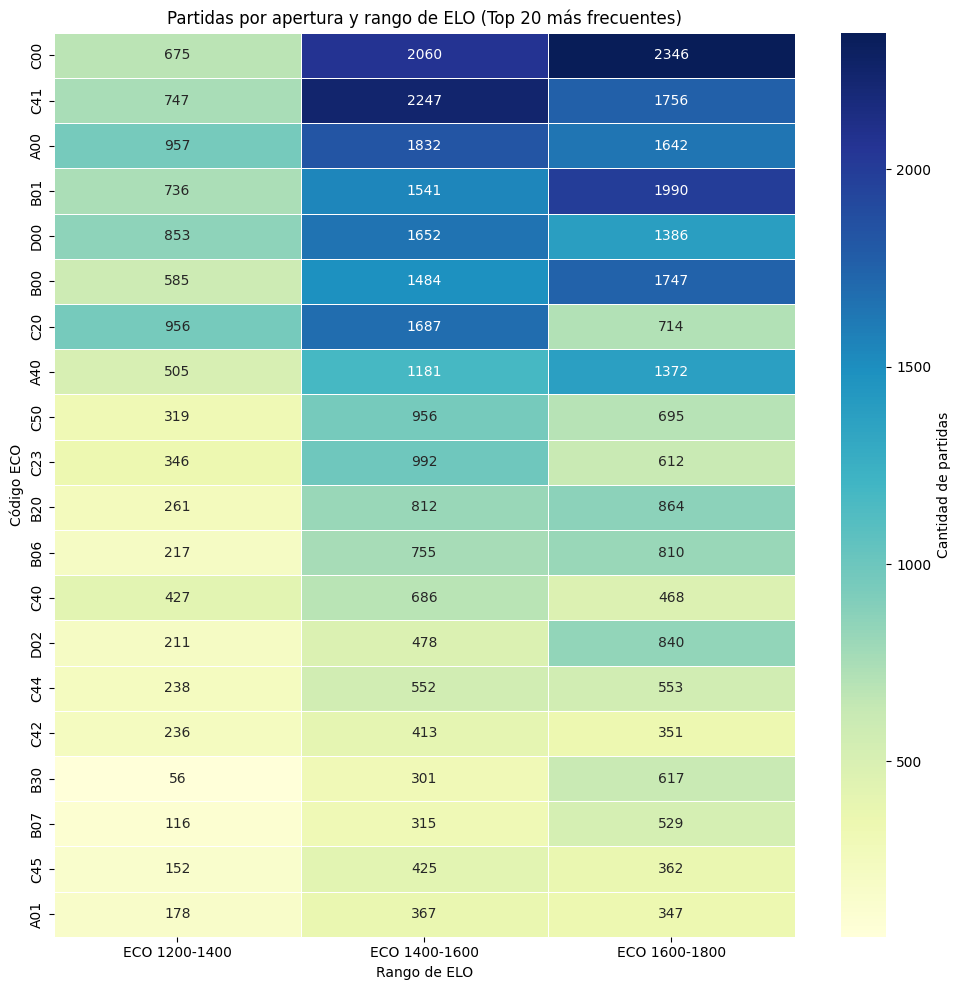

In [ ]:
dfs_aperturas = [
    (df_1200_1400, "1200_1400"),
    (df_1400_1600, "1400_1600"),
    (df_1600_1800, "1600_1800")
]

conteos_aperturas = [contar_aperturas(df, sufijo) for df, sufijo in dfs_aperturas]

aperturas_comunes = reduce(
    lambda izquierda, derecha: pd.merge(izquierda, derecha, on="eco", how="inner"),
    conteos_aperturas
)

columnas_conteo = [f"cantidad_{sufijo}" for _, sufijo in dfs_aperturas]
aperturas_comunes["total"] = aperturas_comunes[columnas_conteo].sum(axis=1)

aperturas_top = aperturas_comunes.sort_values(by="total", ascending=False).head(20)

df_mapa_calor = aperturas_top.set_index("eco")[
    ["cantidad_1200_1400", "cantidad_1400_1600", "cantidad_1600_1800"]
]
df_mapa_calor.columns = ['ECO 1200-1400', 'ECO 1400-1600', 'ECO 1600-1800']

plt.figure(figsize=(10, max(6, len(df_mapa_calor) * 0.5)))
sns.heatmap(df_mapa_calor, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Cantidad de partidas"})
plt.title("Partidas por apertura y rango de ELO (Top 20 más frecuentes)")
plt.xlabel("Rango de ELO")
plt.ylabel("Código ECO")
plt.tight_layout()
plt.show()

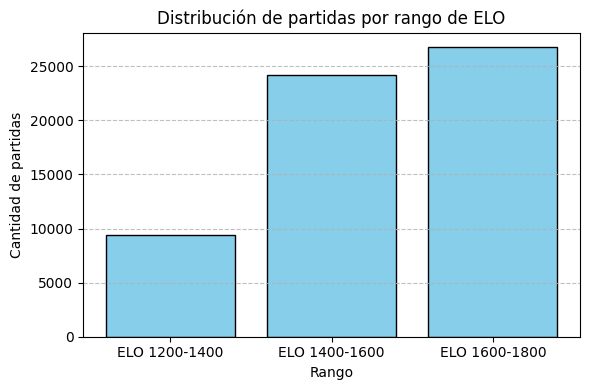

In [ ]:
cantidad = [
    df_1200_1400.shape[0],
    df_1400_1600.shape[0],
    df_1600_1800.shape[0]
]

rango_elo = ['ELO 1200-1400', 'ELO 1400-1600', 'ELO 1600-1800']

plt.figure(figsize=(6, 4))
plt.bar(rango_elo, cantidad, color='skyblue', edgecolor='black')
plt.xlabel('Rango')
plt.ylabel('Cantidad de partidas')
plt.title('Distribución de partidas por rango de ELO')
plt.grid(axis='y', linestyle='--', alpha=0.8)
plt.tight_layout()
plt.show()

## Me quedo con 9000 partidas de cada grupo de ELO

In [ ]:
def muestreo_estratificado_por_apertura(df, n=9000, semilla=42):
    if len(df) <= n:
        return df.copy()
    muestra, _ = train_test_split(
        df,
        train_size=n,
        stratify=df['eco'],
        random_state=semilla
    )
    return muestra

df_1200_1400 = muestreo_estratificado_por_apertura(df_1200_1400, n=9000)
df_1400_1600 = muestreo_estratificado_por_apertura(df_1400_1600, n=9000)
df_1600_1800 = muestreo_estratificado_por_apertura(df_1600_1800, n=9000)

print(df_1200_1400.shape)
print(df_1400_1600.shape)
print(df_1600_1800.shape)

(9000, 12)
(9000, 12)
(9000, 12)


In [ ]:
j_blancos_1200_1400 = df_1200_1400['white_player'].nunique()
j_negros_1200_1400 = df_1200_1400['black_player'].nunique()
jugadores_unicos_1200_1400 = j_blancos_1200_1400 + j_negros_1200_1400

j_blancos_1400_1600 = df_1400_1600['white_player'].nunique()
j_negros_1400_1600 = df_1400_1600['black_player'].nunique()
jugadores_unicos_1400_1600 = j_blancos_1400_1600 + j_negros_1400_1600

j_blancos_1600_1800 = df_1600_1800['white_player'].nunique()
j_negros_1600_1800 = df_1600_1800['black_player'].nunique()
jugadores_unicos_1600_1800 = j_blancos_1600_1800 + j_negros_1600_1800

print(f'Cantidad de jugadores distintos despues de filtrar: \n Elo 1200-1400: {jugadores_unicos_1200_1400} \n Elo 1400-1600: {jugadores_unicos_1400_1600} \n Elo 1600-1800: {jugadores_unicos_1600_1800}')


Cantidad de jugadores distintos despues de filtrar: 
 Elo 1200-1400: 1140 
 Elo 1400-1600: 1937 
 Elo 1600-1800: 1844


In [ ]:
aperturas_distintas_1200_1400 = df_1200_1400['eco'].nunique()
aperturas_distintas_1400_1600 = df_1400_1600['eco'].nunique()
aperturas_distintas_1600_1800 = df_1600_1800['eco'].nunique()

print(f'Cantidad de aperturas distintas después de filtrar: \n Elo 1200-1400: {aperturas_distintas_1200_1400} \n Elo 1400-1600: {aperturas_distintas_1400_1600} \n Elo 1600-1800: {aperturas_distintas_1600_1800}')


Cantidad de aperturas distintas después de filtrar: 
 Elo 1200-1400: 26 
 Elo 1400-1600: 33 
 Elo 1600-1800: 42


## *Creacion matriz Bipartita*

Esta es la base de todo, poder tener una matriz que me indique las aperturas que utilizo un jugador. 


In [ ]:
def crear_matriz_bipartita(df, nombre_variable=None, globals_dict=None):
    white = df[['white_player', 'eco']].rename(columns={'white_player': 'player'})
    white['color'] = 'W'
    black = df[['black_player', 'eco']].rename(columns={'black_player': 'player'})
    black['color'] = 'B'
    all_players = pd.concat([white, black])

    all_players['eco_color'] = all_players['eco'] + '_' + all_players['color']
    matriz_bipartita = all_players.groupby(['player', 'eco_color']).size().gt(0).astype(int).unstack(fill_value=0)

    if nombre_variable is not None and globals_dict is not None:
        globals_dict[nombre_variable] = matriz_bipartita

    return matriz_bipartita

matriz_bipartita_1200_1400 = crear_matriz_bipartita(df_1200_1400, nombre_variable='matriz_bipartita_1200_1400', globals_dict=globals())
matriz_bipartita_1400_1600 = crear_matriz_bipartita(df_1400_1600, nombre_variable='matriz_bipartita_1400_1600', globals_dict=globals())
matriz_bipartita_1600_1800 = crear_matriz_bipartita(df_1600_1800, nombre_variable='matriz_bipartita_1600_1800', globals_dict=globals())


In [ ]:
matriz_bipartita_1600_1800.head()

eco_color,A00_B,A00_W,A01_B,A01_W,A02_B,A02_W,A04_B,A04_W,A40_B,A40_W,...,D02_B,D02_W,D06_B,D06_W,D10_B,D10_W,D20_B,D20_W,D30_B,D30_W
player,,,,,,,,,,,,,,,,,,,,,
A87144434784,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
AS72,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
ATTRV122I,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Aaallister,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
AbbasAbbasIran,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


## *Red de Co-ocurrencia (W) entre Aperturas* 

Una vez que tengo la matriz bipartita \(M\), puedo construir una red de afinidad entre aperturas. 

El producto (M^T x M) es una forma estándar de obtener la matriz de coocurrencias en redes bipartitas. Cada elemento (o1, o2) indica cuántos jugadores comparten ambas aperturas.


In [ ]:
# armo diccionario para poder asignarle a cada nodo el nombre de la apertura
def obtener_mapeo_nodo_a_apertura(matriz_bipartita):
    aperturas = list(matriz_bipartita.columns)  # Lista de nombres de aperturas en el mismo orden que los nodos
    nodo_a_apertura = {i: apertura for i, apertura in enumerate(aperturas)}
    return nodo_a_apertura

nodo_a_apertura_1200_1400 = obtener_mapeo_nodo_a_apertura(matriz_bipartita_1200_1400)
nodo_a_apertura_1400_1600 = obtener_mapeo_nodo_a_apertura(matriz_bipartita_1400_1600)
nodo_a_apertura_1600_1800 = obtener_mapeo_nodo_a_apertura(matriz_bipartita_1600_1800)

In [ ]:
# mejor formato para la matriz
M_1200_1400 = csr_matrix(matriz_bipartita_1200_1400.values)
M_1400_1600 = csr_matrix(matriz_bipartita_1400_1600.values)
M_1600_1800 = csr_matrix(matriz_bipartita_1600_1800.values)

La matriz 𝑊 contiene muchas coocurrencias que pueden surgir simplemente por azar o por la alta
popularidad de ciertas aperturas. Para filtrar estas relaciones espurias, se aplicó un modelo nulo conocido como el Modelo de Configuración Bipartito (Saracco, Di Clemente, Gabrielli, & Squartini, 2015). Este modelo estima qué tan probable es que una coocurrencia observada entre dos aperturas pueda atribuirse al azar, manteniendo constante el grado de cada jugador (es decir, la cantidad de aperturas distintas que utiliza). Las conexiones que sobreviven a este filtro son estadísticamente significativas y representan relaciones más sólidas

In [ ]:
def simular_bipartito(M, n_sim=10, alpha=0.01, semilla=24, nodo_a_apertura=None):
    np.random.seed(semilla)
    num_jugadores, num_aperturas = M.shape
    W_real = M.T @ M  # Coocurrencias reales 
    W_real = W_real.toarray()

    # Guardo las simulaciones
    simulaciones = np.zeros((n_sim, num_aperturas, num_aperturas), dtype=int)

    grados_jugadores = np.array(M.sum(axis=1)).flatten()  # Grado de jugadores
    grados_aperturas = np.array(M.sum(axis=0)).flatten()  # Grado de aperturas

    # Chequeo de consistencia
    if grados_jugadores.sum() != grados_aperturas.sum():
        raise ValueError(f"El número total de stubs de jugadores ({grados_jugadores.sum()}) "
                         f"no coincide con el de aperturas ({grados_aperturas.sum()})")

    for r in tqdm(range(n_sim), desc="Simulando bipartito"):
        # Listas de "stubs"
        stubs_jugadores = np.repeat(np.arange(num_jugadores), grados_jugadores)
        stubs_aperturas = np.repeat(np.arange(num_aperturas), grados_aperturas)

        # Mezclar los stubs
        np.random.shuffle(stubs_aperturas)
        np.random.shuffle(stubs_jugadores)

        # Si hay más stubs de un lado, recortar para igualar
        n_enlaces = min(len(stubs_jugadores), len(stubs_aperturas))
        enlaces = list(zip(stubs_jugadores[:n_enlaces], stubs_aperturas[:n_enlaces]))

        if not enlaces:
            continue

        filas, columnas = zip(*enlaces)
        M_sim = csr_matrix((np.ones(len(enlaces)), (filas, columnas)), shape=(num_jugadores, num_aperturas))
        W_sim = M_sim.T @ M_sim
        simulaciones[r] = W_sim.toarray()

    # p-valor para cada par
    pvalores = np.mean(simulaciones >= W_real[None, :, :], axis=0)
    mascara_valida = np.ones((num_aperturas, num_aperturas), dtype=bool)
    np.fill_diagonal(mascara_valida, False)
    # Filtrado por significancia
    W_filtrada = (W_real * (pvalores < alpha) * mascara_valida).astype(int)

    return W_filtrada, W_real, pvalores, mascara_valida

In [ ]:
W_1200_1400, W_real_1200_1400, pvals, nodo_a_apertura_1200_1400= simular_bipartito(M_1200_1400, n_sim=5000, alpha=0.05, semilla=42, nodo_a_apertura= nodo_a_apertura_1200_1400)

Simulando bipartito: 100%|██████████| 5000/5000 [00:28<00:00, 177.14it/s]


In [ ]:
W_1400_1600, W_real_1400_1600, pvals, nodo_a_apertura_1400_1600= simular_bipartito(M_1400_1600, n_sim=5000, alpha=0.05, semilla=42, nodo_a_apertura= nodo_a_apertura_1400_1600)

Simulando bipartito: 100%|██████████| 5000/5000 [00:38<00:00, 129.39it/s]


In [ ]:
W_1600_1800, W_real_1600_1800, pvals, nodo_a_apertura_1600_1800= simular_bipartito(M_1600_1800, n_sim=5000, alpha=0.05, semilla=42, nodo_a_apertura= nodo_a_apertura_1600_1800)

Simulando bipartito: 100%|██████████| 5000/5000 [00:43<00:00, 116.10it/s]


In [ ]:
def graficar_mapas_calor_coocurrencia(matriz_real, matriz_filtrada, prefijo_titulo=''):
    figura, ejes = plt.subplots(1, 2, figsize=(16, 8))
    
    imagen0 = ejes[0].matshow(matriz_real, cmap='viridis')
    barra_color0 = figura.colorbar(imagen0, ax=ejes[0], shrink=0.8)
    barra_color0.set_label('Número de jugadores en común', rotation=270, labelpad=20)
    ejes[0].set_title(f'{prefijo_titulo} Coocurrencia observada', fontsize=14)
    ejes[0].tick_params(axis='both', which='major', labelsize=8)
    
    imagen1 = ejes[1].matshow(matriz_filtrada, cmap='viridis')
    barra_color1 = figura.colorbar(imagen1, ax=ejes[1], shrink=0.8)
    barra_color1.set_label('Número de jugadores en común', rotation=270, labelpad=20)
    ejes[1].set_title(f'{prefijo_titulo} Coocurrencia filtrada', fontsize=14)
    ejes[1].tick_params(axis='both', which='major', labelsize=8)
    
    plt.tight_layout()
    plt.show()

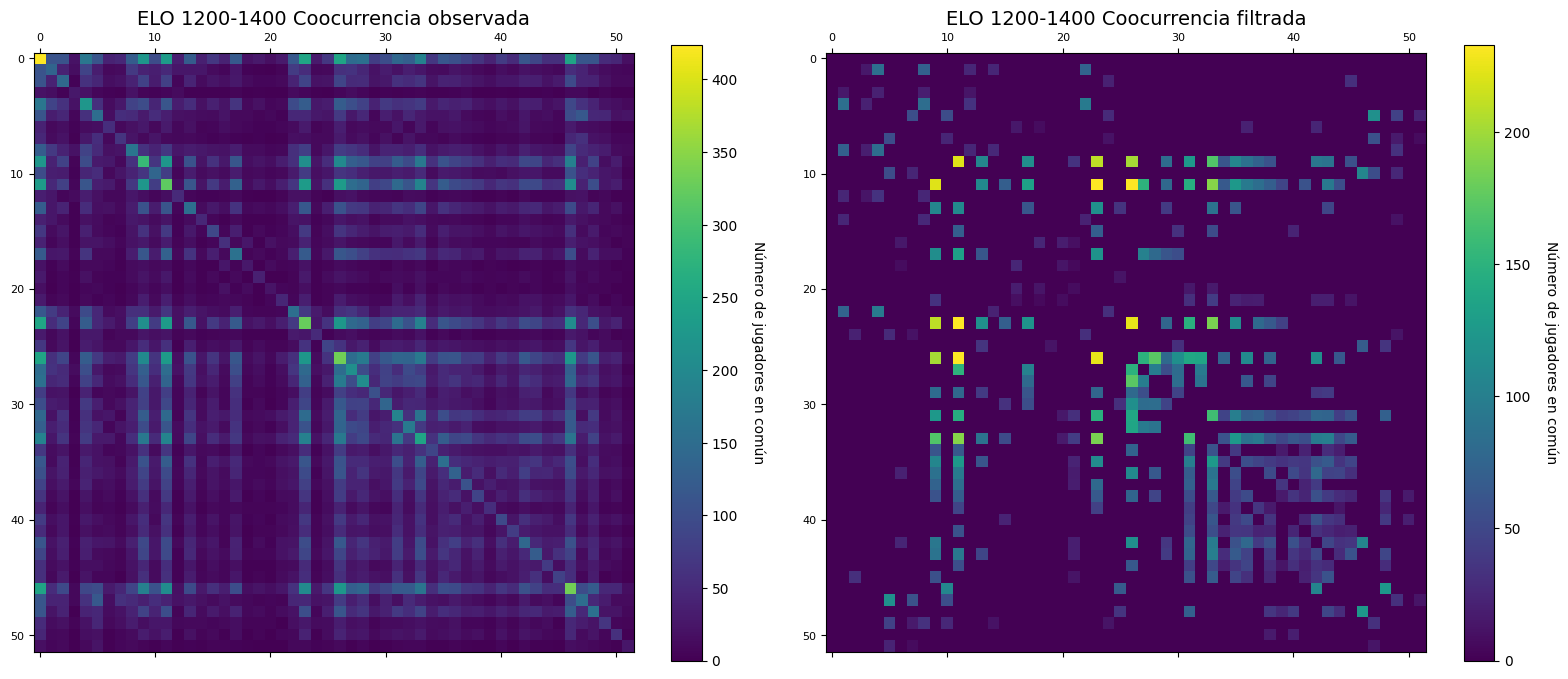

In [ ]:
graficar_mapas_calor_coocurrencia(W_real_1200_1400, W_1200_1400 , prefijo_titulo="ELO 1200-1400")

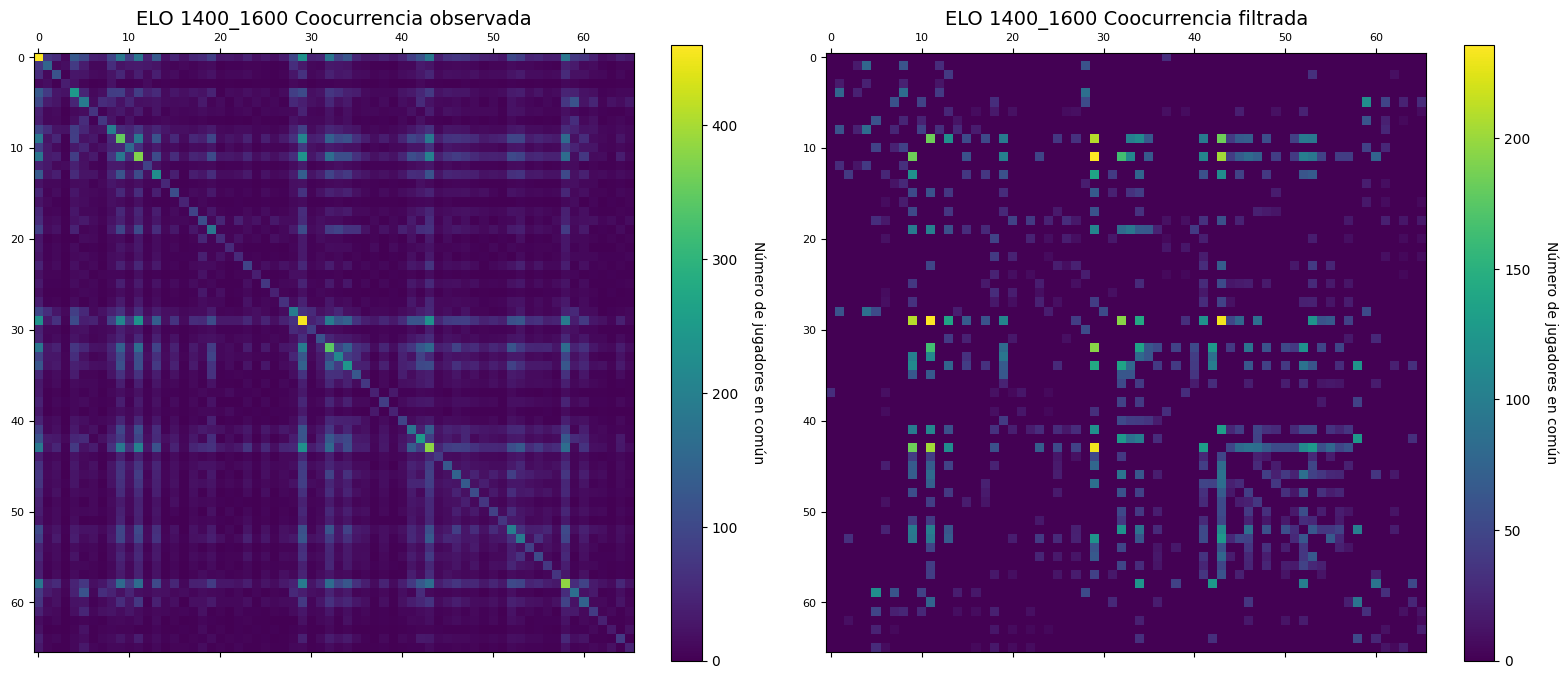

In [ ]:
graficar_mapas_calor_coocurrencia(W_real_1400_1600, W_1400_1600, prefijo_titulo="ELO 1400_1600")


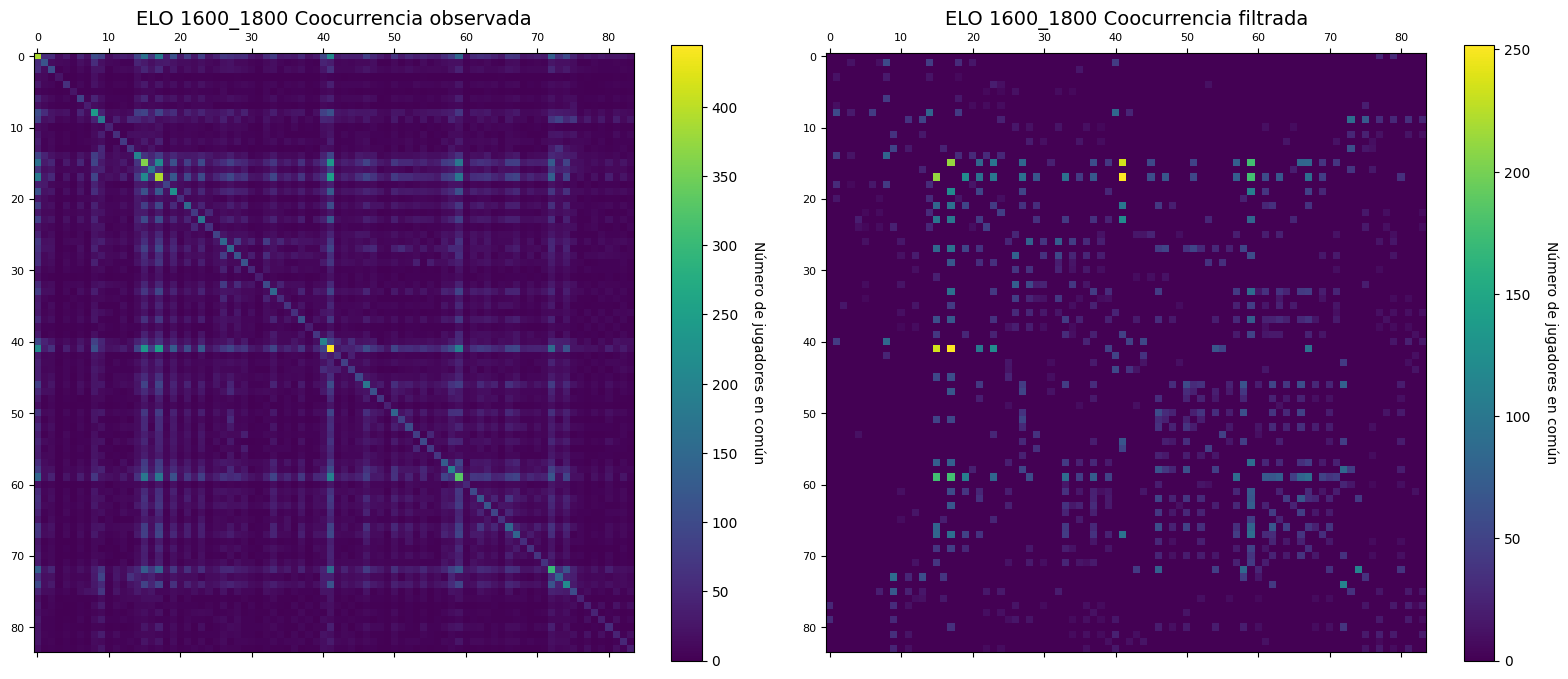

In [ ]:
graficar_mapas_calor_coocurrencia(W_real_1600_1800, W_1600_1800, prefijo_titulo="ELO 1600_1800")

# Primer vista del grafo

In [ ]:
def analizar_grafo(W_filtered, usar_pesos=True):

    Grafo = nx.from_numpy_array(W_filtered)
    info = {
        'es_multigrafo': Grafo.is_multigraph(),
        'es_dirigido': nx.is_directed(Grafo),
        'es_pesado': nx.is_weighted(Grafo),
        'es_conectado': nx.is_connected(Grafo)
    }
    print('Grafo observado:')
    print(Grafo)
    print('Es multigrafo?:', info['es_multigrafo'])
    print('Es dirigido?:', info['es_dirigido'])
    print('Es pesado?:', info['es_pesado'])
    print('Es conectado?:', info['es_conectado'])
    
    edges = Grafo.edges(data=True)
    if usar_pesos:
        pesos = [d.get('weight', 1) for (u, v, d) in edges]
    else:

        pesos = [1 for (u, v, d) in edges]
    
    # Normalización de pesos para el grosor de las aristas
    if len(pesos) > 0:
        min_peso = min(pesos)
        max_peso = max(pesos)
        if max_peso > min_peso:
            widths = [1 + 4 * (p - min_peso) / (max_peso - min_peso) for p in pesos]
        else:
            widths = [2 for _ in pesos]
    else:
        widths = 1

    pos = nx.spring_layout(Grafo, seed=42)
    fig, ax = plt.subplots(figsize=(8, 6))
    nx.draw(
        Grafo, 
        pos=pos, 
        labels={i: i for i in Grafo.nodes}, 
        with_labels=True, 
        width=widths, 
        edge_color=pesos, 
        edge_cmap=plt.cm.Blues if usar_pesos else None, 
        node_color="#A0CBE2",
        ax=ax
    )
    if usar_pesos and len(pesos) > 0 and max(pesos) > min(pesos):
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=min(pesos), vmax=max(pesos)))
        sm.set_array([])
        plt.colorbar(sm, label="Peso de la arista", ax=ax)
    plt.show()

Grafo observado:
Graph with 52 nodes and 223 edges
Es multigrafo?: False
Es dirigido?: False
Es pesado?: True
Es conectado?: False


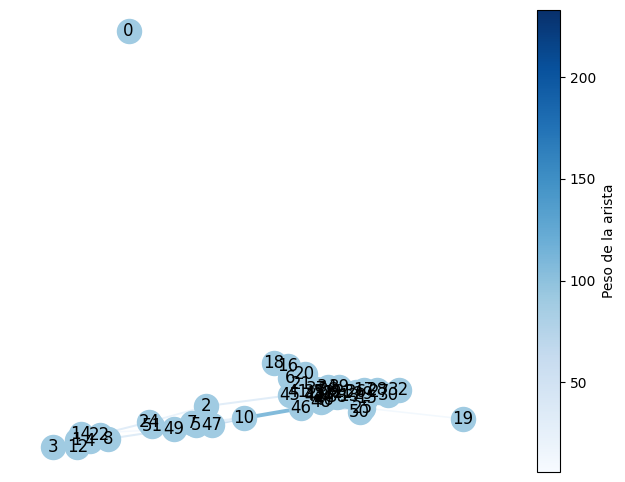

In [ ]:
analizar_grafo(W_1200_1400)

Grafo observado:
Graph with 66 nodes and 335 edges
Es multigrafo?: False
Es dirigido?: False
Es pesado?: True
Es conectado?: True


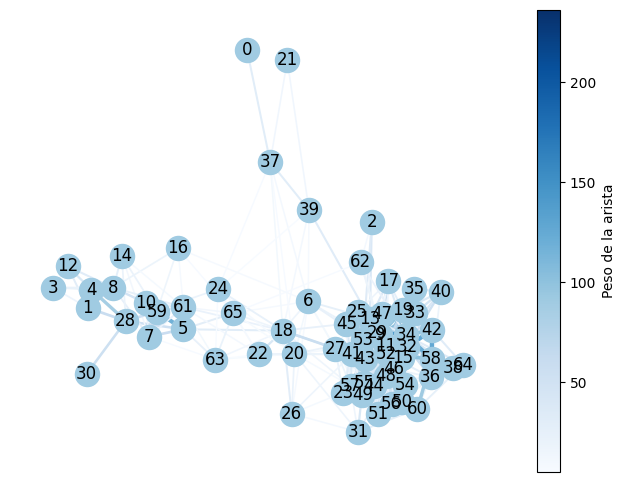

In [ ]:
analizar_grafo(W_1400_1600)

Grafo observado:
Graph with 84 nodes and 391 edges
Es multigrafo?: False
Es dirigido?: False
Es pesado?: True
Es conectado?: True


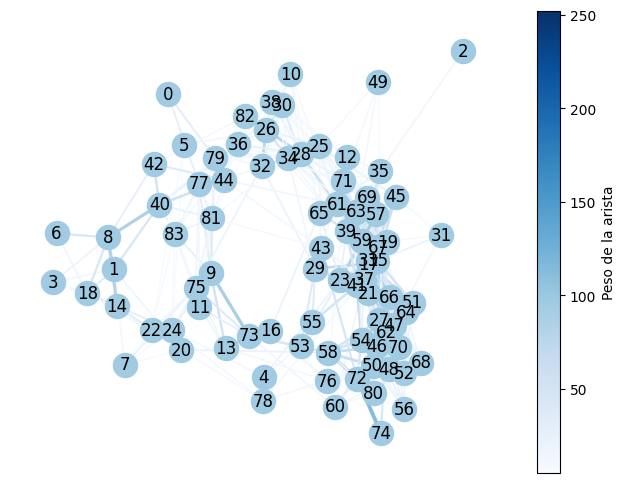

In [ ]:
analizar_grafo(W_1600_1800)

## Obtengo la componente conectada de cada red con la cual voy a trabajar. 

In [ ]:
def obtener_mapeo_aperturas(df):
    aperturas = list(df.columns)
    nodo_a_apertura = {i: apertura for i, apertura in enumerate(aperturas)}
    return aperturas, nodo_a_apertura

aperturas_1200_1400,nodo_a_apertura_1200_1400=obtener_mapeo_aperturas(matriz_bipartita_1200_1400)
aperturas_1400_1600,nodo_a_apertura_1400_1600=obtener_mapeo_aperturas(matriz_bipartita_1400_1600)
aperturas_1600_1800,nodo_a_apertura_1600_1800=obtener_mapeo_aperturas(matriz_bipartita_1600_1800)


In [ ]:
def grafo_componente_principal(W_filtered, aperturas):
    W_df = pd.DataFrame(W_filtered, index=aperturas, columns=aperturas)
    G = nx.from_pandas_adjacency(W_df)
    componentes = list(nx.connected_components(G))
    mayor_componente = max(componentes, key=len)
    G_mayor = G.subgraph(mayor_componente).copy()
    nombres_componentes_principales = list(G_mayor.nodes)
    print(f"Número de nodos en la componente principal: {len(nombres_componentes_principales)}")    
    return G_mayor, nombres_componentes_principales

## Grafo pesado


In [ ]:
G_mayor_1200_1400, nombres_componentes_principales_1200_1400 = grafo_componente_principal(W_1200_1400, aperturas_1200_1400)

Número de nodos en la componente principal: 51


In [ ]:
G_mayor_1400_1600, nombres_componentes_principales_1400_1600 = grafo_componente_principal(W_1400_1600, aperturas_1400_1600)

Número de nodos en la componente principal: 66


In [ ]:
G_mayor_1600_1800, nombres_componentes_principales_1600_1800 = grafo_componente_principal(W_1600_1800, aperturas_1600_1800)

Número de nodos en la componente principal: 84


# Plot grafos componente gigante

In [ ]:
def grafo(G,
        dibujar=True,
        k_layout=0.15,
        seed=42,
        titulo="Grafo de coocurrencia"):
    
    info = {
        'N_nodos': G.number_of_nodes(),
        'N_aristas': G.number_of_edges(),
        'grado_medio': np.mean([d for _, d in G.degree()]),
        'peso_promedio': np.mean([d.get('weight',1) for *_,d in G.edges(data=True)])
    }

    print("→ N nodos:      ", info['N_nodos'])
    print("→ N aristas:    ", info['N_aristas'])
    print("→ Grado medio:  ", f"{info['grado_medio']:.2f}")
    print("→ Peso medio:   ", f"{info['peso_promedio']:.2f}")

    if dibujar and info['N_nodos'] > 0:
        pos = nx.spring_layout(G, k=k_layout, seed=seed)

        node_colors = "#A0CBE2"

        grados = dict(G.degree())
        sizes = [50 + 200*(grados[n]/max(grados.values())) for n in G.nodes()]

        raw_weights = np.array([d.get('weight',1) for *_,d in G.edges(data=True)])
        w2 = raw_weights
        
        mi, ma = w2.min(), w2.max()
        widths = 1 + 2*(w2 - mi)/(ma - mi) if ma > mi else np.full_like(w2,2.0)
        alphas = 0.5 + 0.5*(w2 - mi)/(ma - mi)

        fig, ax = plt.subplots(figsize=(9,7))
        
        nx.draw_networkx_edges(
            G, pos,
            width=widths,
            alpha=alphas,
            edge_color=raw_weights,
            edge_cmap=plt.cm.Blues,
            ax=ax
        )
        
        nx.draw_networkx_nodes(
            G, pos,
            node_size=sizes,
            node_color=node_colors,
            ax=ax
        )
        
        nx.draw_networkx_labels(
            G, pos,
            font_size=8,
            font_color='black',
            ax=ax
        )
        
        ax.set_axis_off()
        plt.title(titulo, fontsize=14)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues,
                                   norm=plt.Normalize(vmin=raw_weights.min(),
                                                      vmax=raw_weights.max()))
        sm.set_array([])
        plt.colorbar(sm, label="Peso de arista", ax=ax)
        plt.show()

→ N nodos:       51
→ N aristas:     223
→ Grado medio:   8.75
→ Peso medio:    62.33


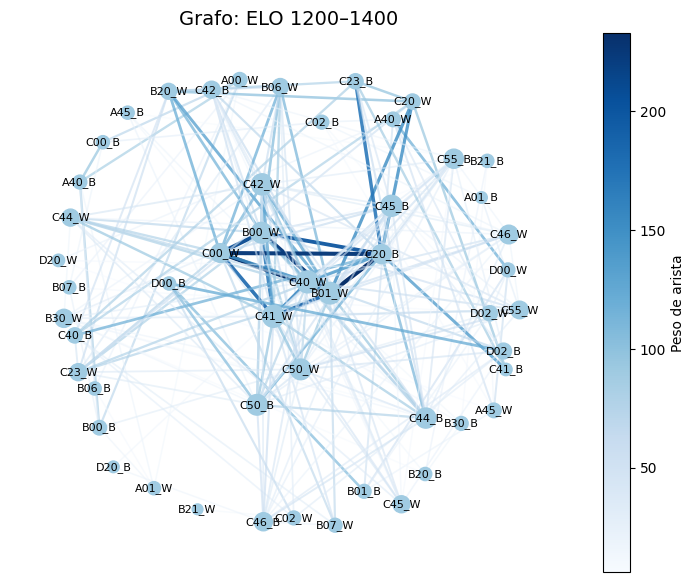

In [ ]:
grafo(G_mayor_1200_1400,
    dibujar=True,
    k_layout=8,
    seed=42,
    titulo="Grafo: ELO 1200–1400")

→ N nodos:       66
→ N aristas:     335
→ Grado medio:   10.15
→ Peso medio:    45.93


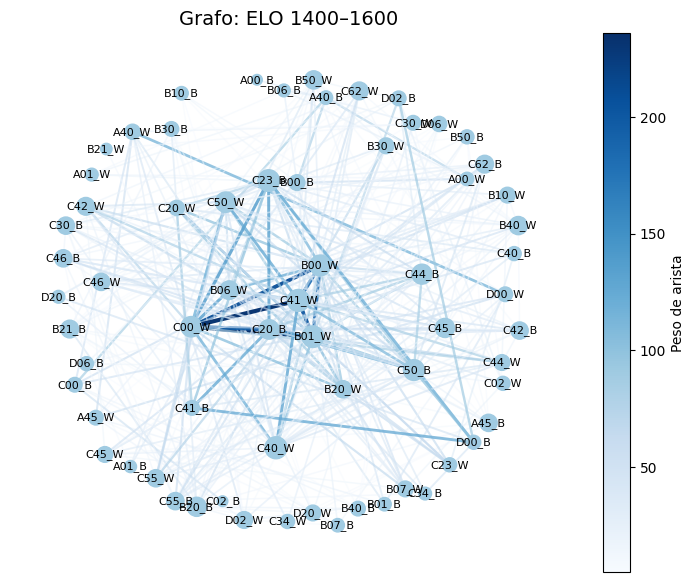

In [ ]:
grafo(G_mayor_1400_1600,
    dibujar=True,
    k_layout=8,
    seed=42,
    titulo="Grafo: ELO 1400–1600")

→ N nodos:       84
→ N aristas:     391
→ Grado medio:   9.31
→ Peso medio:    33.60


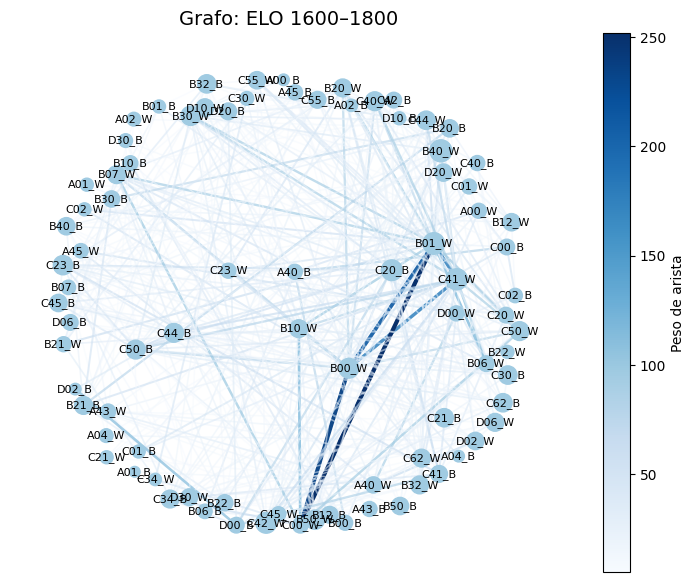

In [ ]:
grafo(G_mayor_1600_1800,
    dibujar=True,
    k_layout=8,
    seed=42,
    titulo="Grafo: ELO 1600–1800")

## Topologia de la red. 



In [ ]:
def plot_dist_nodos_pesos(graphs,
                          labels=None,
                          bins=30,
                          figsize_per_graph=(8, 4)):
    if labels is None:
        labels = [f"Grafo {i+1}" for i in range(len(graphs))]
    n = len(graphs)
    fig, axes = plt.subplots(n, 2,
                             figsize=(figsize_per_graph[0],
                                      figsize_per_graph[1] * n),
                             sharex=False)
    if n == 1:
        axes = np.array([axes])
    
    for i, (G, label) in enumerate(zip(graphs, labels)):
        ax_deg, ax_wt = axes[i]

        grados = [d for _, d in G.degree()]
        if grados:
            vals, counts = np.unique(grados, return_counts=True)
            ax_deg.bar(vals, counts, alpha=0.8, width=0.8)
        ax_deg.set_title(f"{label} — Grados")
        ax_deg.set_xlabel("Grado")
        ax_deg.set_ylabel("# Nodos")
        ax_deg.grid(alpha=0.3)

        
        pesos = [data.get('weight', 1) for u, v, data in G.edges(data=True)]
        ax_wt.set_title(f"{label} — Pesos de enlaces")
        if not pesos:
            ax_wt.text(0.5, 0.5, "(sin pesos)", ha='center', va='center')
        else:
            ax_wt.hist(pesos, bins=bins, density=True, alpha=0.6)
            ax_wt.set_xlabel("Peso")
            ax_wt.set_ylabel("Proporción")
        ax_wt.grid(alpha=0.3)

    fig.suptitle("Propiedades de la red: grados y pesos de enlaces", fontsize=16)
    fig.canvas.draw() 
    fig_width, fig_height = fig.get_size_inches()
    fig_line_y = 0.95  
    fig_line = plt.Line2D([0.05, 0.95], [fig_line_y, fig_line_y], color='black', linewidth=1, transform=fig.transFigure, clip_on=False)
    fig.add_artist(fig_line)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


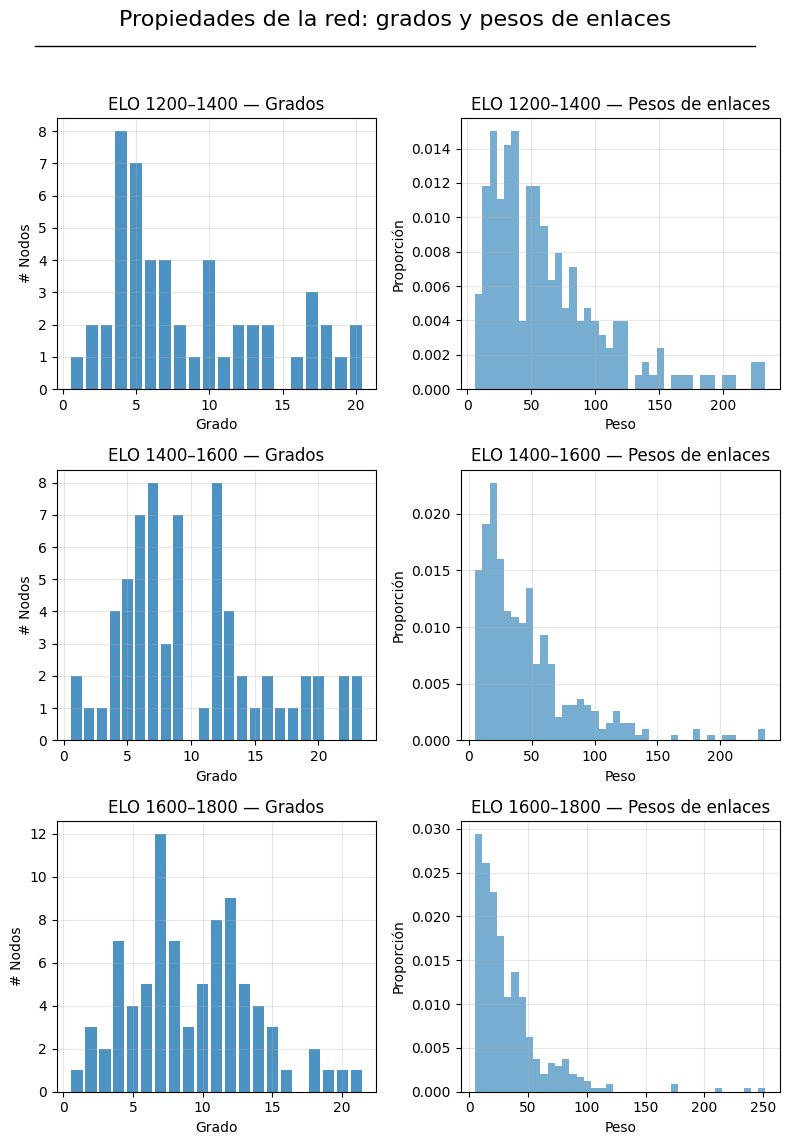

In [ ]:
plot_dist_nodos_pesos(
    graphs=[G_mayor_1200_1400, G_mayor_1400_1600, G_mayor_1600_1800],
    labels=["ELO 1200–1400", "ELO 1400–1600", "ELO 1600–1800"],
    bins=40
)

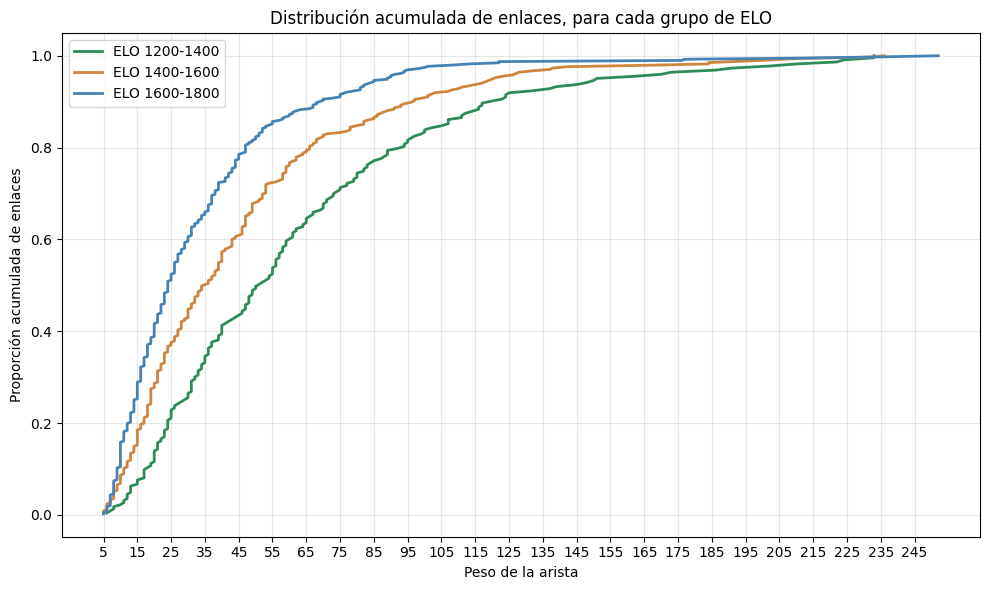

In [ ]:
def graficar_distribucion_acumulada_pesos(grafos, etiquetas=None):
    if etiquetas is None:
        etiquetas = [f"Grafo {i+1}" for i in range(len(grafos))]
    
    lista_pesos = []
    for G in grafos:
        pesos = [data['weight'] for u, v, data in G.edges(data=True) if 'weight' in data]
        lista_pesos.append(pesos)
    
    plt.figure(figsize=(10, 6))
    colores = ['#2E8B57', '#CD853F', '#4682B4', '#DC143C', '#9370DB', '#FF8C00']
    
    minimo_x = None
    maximo_x = None

    for i, (pesos, etiqueta) in enumerate(zip(lista_pesos, etiquetas)):
        if len(pesos) > 0:
            pesos_ordenados = np.sort(pesos)
            n = len(pesos_ordenados)
            ecdf_y = np.arange(1, n+1) / n

            if minimo_x is None or pesos_ordenados[0] < minimo_x:
                minimo_x = pesos_ordenados[0]
            if maximo_x is None or pesos_ordenados[-1] > maximo_x:
                maximo_x = pesos_ordenados[-1]
            
            plt.plot(pesos_ordenados, ecdf_y, label=etiqueta, 
                     color=colores[i % len(colores)], linewidth=2)
    
    plt.xlabel('Peso de la arista')
    plt.ylabel('Proporción acumulada de enlaces')
    plt.title('Distribución acumulada de enlaces, para cada grupo de ELO')
    plt.legend()
    plt.grid(True, alpha=0.3)

    if minimo_x is not None and maximo_x is not None:
        try:
            min_tick = int(np.floor(minimo_x))
            max_tick = int(np.ceil(maximo_x))
            if max_tick - min_tick > 10:
                ticks = np.arange(min_tick, max_tick+1, 10)
                plt.xticks(ticks)
        except Exception:
            pass  

    plt.tight_layout()
    plt.show()


grafos_elo = [G_mayor_1200_1400, G_mayor_1400_1600, G_mayor_1600_1800]
etiquetas_elo = ["ELO 1200-1400", "ELO 1400-1600", "ELO 1600-1800"]

graficar_distribucion_acumulada_pesos(grafos_elo, etiquetas_elo)

## Metricas

In [ ]:
def metricas_ponderadas(G, verbose=False):
    resultados = {}

    n_nodos = G.number_of_nodes()
    n_aristas = G.number_of_edges()
    resultados['n_nodos'] = n_nodos
    resultados['n_aristas'] = n_aristas

    # 1. Densidad ponderada
    # Dw = (1 / (N(N-1))) * suma de todos los pesos normalizados
    peso_total = sum([edata['weight'] for _,_,edata in G.edges(data=True)])
    peso_max = max([edata['weight'] for _,_,edata in G.edges(data=True)])
    
    # Normalizar pesos dividiendo por el peso máximo
    suma_pesos_normalizados = sum([edata['weight']/peso_max for _,_,edata in G.edges(data=True)])
    densidad_ponderada = suma_pesos_normalizados / (n_nodos * (n_nodos - 1))
    resultados['densidad_ponderada'] = densidad_ponderada

    # 2. Coeficiente de clustering ponderado (promedio)
    # Usa la implementación de NetworkX que sigue el método de Barrat et al.
    clustering_ponderado = nx.average_clustering(G, weight='weight')
    resultados['clustering_ponderado'] = clustering_ponderado

    # 3. Modularidad ponderada usando detección de comunidades Louvain
    try:
        
        import networkx.algorithms.community as nx_comm
        comunidades = nx_comm.louvain_communities(G, weight='weight')
        
        # Calcular modularidad ponderada
        modularidad_ponderada = nx_comm.modularity(G, comunidades, weight='weight')
        resultados['modularidad_ponderada'] = modularidad_ponderada
    except:
        # Si hay algún error con la detección de comunidades
        resultados['modularidad_ponderada'] = 0.0

    # 4. Transitividad ponderada
    transitividad_ponderada = nx.transitivity(G)  
    triangulos_ponderados = 0
    tripletas_ponderadas = 0
    
    for nodo in G.nodes():
        vecinos = list(G.neighbors(nodo))
        if len(vecinos) >= 2:
            for i in range(len(vecinos)):
                for j in range(i+1, len(vecinos)):
                    v1, v2 = vecinos[i], vecinos[j]
                    peso_nodo_v1 = G[nodo][v1]['weight']
                    peso_nodo_v2 = G[nodo][v2]['weight']
                    tripletas_ponderadas += (peso_nodo_v1 + peso_nodo_v2) / 2
                    if G.has_edge(v1, v2):
                        peso_v1_v2 = G[v1][v2]['weight']
                        triangulos_ponderados += (peso_nodo_v1 + peso_nodo_v2 + peso_v1_v2) / 3
    
    if tripletas_ponderadas > 0:
        transitividad_ponderada = triangulos_ponderados / tripletas_ponderadas
    else:
        transitividad_ponderada = 0.0
    
    resultados['transitividad_ponderada'] = transitividad_ponderada

    asortatividad_ponderada = nx.degree_assortativity_coefficient(G, weight='weight')
    resultados['asortatividad_ponderada'] = asortatividad_ponderada

    if verbose:
        print("----- Medidas topológicas ponderadas -----")
        print(f"Número de nodos: {resultados['n_nodos']}")
        print(f"Número de aristas: {resultados['n_aristas']}")
        print(f"Densidad ponderada: {resultados['densidad_ponderada']:.6f}")
        print(f"Clustering ponderado: {resultados['clustering_ponderado']:.6f}")
        print(f"Modularidad ponderada: {resultados['modularidad_ponderada']:.6f}")
        print(f"Transitividad ponderada: {resultados['transitividad_ponderada']:.6f}")
        print(f"Asortatividad ponderada: {resultados['asortatividad_ponderada']:.6f}")

    df_resultados = pd.DataFrame(list(resultados.items()), columns=['metrica', 'valor_normalizado'])
    return df_resultados

In [ ]:
metricas_1200_1400_ponderadas = metricas_ponderadas(G_mayor_1200_1400)

In [ ]:
metricas_1400_1600_ponderadas= metricas_ponderadas(G_mayor_1400_1600)

In [ ]:
metricas_1600_1800_ponderadas=metricas_ponderadas(G_mayor_1600_1800)

In [ ]:
df_1200_1400_metricas_ponderadas = metricas_1200_1400_ponderadas.rename(columns={'valor_normalizado': 'ELO 1200-1400'})
df_1400_1600_metricas_ponderadas = metricas_1400_1600_ponderadas.rename(columns={'valor_normalizado': 'ELO 1400-1600'})
df_1600_1800_metricas_ponderadas = metricas_1600_1800_ponderadas.rename(columns={'valor_normalizado': 'ELO 1600-1800'})

metricas_totales = df_1200_1400_metricas_ponderadas[['metrica', 'ELO 1200-1400']].merge(
    df_1400_1600_metricas_ponderadas[['metrica', 'ELO 1400-1600']], on='metrica'
).merge(
    df_1600_1800_metricas_ponderadas[['metrica', 'ELO 1600-1800']], on='metrica'
)

metricas_totales

,metrica,ELO 1200-1400,ELO 1400-1600,ELO 1600-1800
0,n_nodos,51.000000,66.000000,84.000000
1,n_aristas,223.000000,335.000000,391.000000
2,densidad_ponderada,0.023395,0.015199,0.007478
3,clustering_ponderado,0.136121,0.088696,0.054263
4,modularidad_ponderada,0.312534,0.308167,0.487990
5,transitividad_ponderada,0.607501,0.502561,0.463859
6,asortatividad_ponderada,0.228610,0.154250,0.260924


In [ ]:
reemplazos = {
    'n_nodos': 'Nodos',
    'n_aristas': 'Aristas',
    'densidad_ponderada': 'Densidad',
    'clustering_ponderado': 'Clustering',
    'modularidad_ponderada': 'Modularidad',
    'transitividad_ponderada': 'Transitividad',
    'asortatividad_ponderada': 'Asortatividad',
}

metricas_totales['metrica'] = metricas_totales['metrica'].replace(reemplazos)
metricas_totales

,metrica,ELO 1200-1400,ELO 1400-1600,ELO 1600-1800
0,Nodos,51.000000,66.000000,84.000000
1,Aristas,223.000000,335.000000,391.000000
2,Densidad,0.023395,0.015199,0.007478
3,Clustering,0.136121,0.088696,0.054263
4,Modularidad,0.312534,0.308167,0.487990
5,Transitividad,0.607501,0.502561,0.463859
6,Asortatividad,0.228610,0.154250,0.260924


In [ ]:
import jinja2


## Deteccion de comunidades

In [ ]:
def detectar_comunidades(G):
    comunidades = list(community.greedy_modularity_communities(G))
    return comunidades

def graficar_comunidades(G, comunidades, elo_titulo=None):
    modularidades_ponderadas = []
    for comunidad in comunidades:
        subgrafo = G.subgraph(comunidad)
        try:
            df_metricas = metricas_ponderadas(subgrafo)
            modularidad_ponderada = df_metricas[df_metricas['metrica'] == 'modularidad_ponderada']['valor_normalizado'].values
            modularidad_ponderada = float(modularidad_ponderada[0]) if len(modularidad_ponderada) > 0 else None
        except Exception as e:
            modularidad_ponderada = None
        modularidades_ponderadas.append(modularidad_ponderada)

    mapa_colores_nodos = {}
    lista_colores = list(mcolors.TABLEAU_COLORS) + list(mcolors.CSS4_COLORS)
    colores_comunidades = {}
    
    for idx, comunidad in enumerate(comunidades):
        color = lista_colores[idx % len(lista_colores)]
        colores_comunidades[idx] = color
        for nodo in comunidad:
            mapa_colores_nodos[nodo] = color

    colores_nodos = [mapa_colores_nodos.get(n, "#cccccc") for n in G.nodes()]
    
    bordes_nodos = []
    for _ in G.nodes():
        bordes_nodos.append('gray')
    
    plt.figure(figsize=(10, 8))
    posiciones = nx.spring_layout(G, seed=42)
    
    nx.draw_networkx_nodes(G, posiciones, node_color=colores_nodos, node_size=200, alpha=0.85,
                          edgecolors=bordes_nodos, linewidths=1)
    nx.draw_networkx_edges(G, posiciones, alpha=0.2)
    
    nx.draw_networkx_labels(G, posiciones, font_size=7, font_weight='bold', alpha=0.9)

    elementos_leyenda = []
    for idx, comunidad in enumerate(comunidades):
        color = lista_colores[idx % len(lista_colores)]
        mod_pond = modularidades_ponderadas[idx]
        if mod_pond is not None:
            etiqueta = f'Comunidad {idx+1} (mod={mod_pond:.3f})'
        else:
            etiqueta = f'Comunidad {idx+1} (mod=N/A)'
        elementos_leyenda.append(plt.Line2D([0], [0], marker='o', color='w', 
                                        markerfacecolor=color, markersize=10,
                                        label=etiqueta))

    plt.legend(handles=elementos_leyenda, loc='upper left')

    titulo = f"Comunidades de Aperturas - ELO {elo_titulo}" if elo_titulo else "Comunidades de Aperturas"
    plt.title(titulo)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def calcular_metricas_grafo(G, comunidades):
    mod = modularity(G, comunidades)
    info_comunidades = []
    for i, comunidad in enumerate(comunidades[:5]):
        subgrafo = G.subgraph(comunidad)
        try:
            df_metricas = metricas_ponderadas(subgrafo)
            modularidad_ponderada = df_metricas[df_metricas['metrica'] == 'modularidad_ponderada']['valor_normalizado'].values
            modularidad_ponderada = float(modularidad_ponderada[0]) if len(modularidad_ponderada) > 0 else None
        except Exception as e:
            modularidad_ponderada = None
        info_comunidades.append({
            'familia': i+1,
            'tamaño': len(comunidad),
            'miembros': list(comunidad)[:10],
            'cohesion': nx.density(subgrafo),
            'modularidad_ponderada': modularidad_ponderada
        })
    
    return {
        'modularidad': mod,
        'comunidades': info_comunidades
    }

def metricas_dentro_comunidades(G, comunidades):
    metricas_comunidad = {}
    top_n = len(comunidades)
    comunidades_ordenadas = sorted(comunidades, key=len, reverse=True)[:top_n]

    todas_metricas = {}
    for i, comunidad in enumerate(comunidades_ordenadas):
        subgrafo = G.subgraph(comunidad).copy()
        try:
            df_m = metricas_ponderadas(subgrafo)
            metricas_comunidad[f'comunidad_{i+1}'] = {
                'tamaño': len(subgrafo),
                'nodos': list(subgrafo.nodes)[:10],
                'metricas': df_m
            }

            for _, fila in df_m.iterrows():
                metrica = fila['metrica']
                valor = fila['valor_normalizado']
                if metrica not in todas_metricas:
                    todas_metricas[metrica] = {}
                todas_metricas[metrica][f'Comunidad {i+1}'] = valor
            
            print(f"\n>>> Comunidad {i+1} (n={len(subgrafo)}):")
            print(f"Nodos principales: {list(subgrafo.nodes)[:5]}")
                
        except Exception as e:
            print(f"Error analizando comunidad {i+1}: {e}")
    
    if todas_metricas:
        df_consolidado = pd.DataFrame(todas_metricas).T
        df_consolidado = df_consolidado.fillna(0)
        print(f"\n=== TABLA CONSOLIDADA DE MÉTRICAS POR COMUNIDAD ===")
        print(df_consolidado.round(4))
        return metricas_comunidad, df_consolidado
    return metricas_comunidad, None

def analizar_coocurrencia_relevante(G, elo_titulo):
    print(f"=== ANÁLISIS DE COOCURRENCIA - ELO {elo_titulo} ===")
    comunidades = detectar_comunidades(G)

    diccionario_comunidades = {}
    for i, comunidad in enumerate(comunidades):
        diccionario_comunidades[f'Comunidad {i+1}'] = list(comunidad)

    metricas = calcular_metricas_grafo(G, comunidades)
    
    print(f"\n=== FAMILIAS DE APERTURAS ===")
    print(f"Modularidad global: {metricas['modularidad']:.3f}")
    print(f"Número total de comunidades: {len(comunidades)}")
    

    print("\n--- Modularidad de cada comunidad ---")
    for info in metricas['comunidades']:
        print(f"\nFamilia {info.get('familia', 'N/A')}:")
        print(f"  Tamaño: {info.get('tamaño', 'N/A')}")
        print(f"  Miembros: {info.get('miembros', 'N/A')}...")
        print(f"  Cohesión: {info.get('cohesion', 'N/A'):.3f}" if 'cohesion' in info else "  Cohesión: N/A")

        if 'modularidad_ponderada' in info and info['modularidad_ponderada'] is not None:
            print(f"  Modularidad (ponderada): {info['modularidad_ponderada']:.3f}")
        elif 'modularidad' in info:
            print(f"  Modularidad: {info['modularidad']:.3f}")
        else:
            print("  Modularidad: N/A")
    
    graficar_comunidades(G, comunidades, elo_titulo)

    print(f"\n=== MÉTRICAS DE CADA COMUNIDAD ===")
    tabla_consolidada = metricas_dentro_comunidades(G, comunidades)
    
    return tabla_consolidada, diccionario_comunidades

=== ANÁLISIS DE COOCURRENCIA - ELO 1200-1400 ===

=== FAMILIAS DE APERTURAS ===
Modularidad global: 0.302
Número total de comunidades: 4

--- Modularidad de cada comunidad ---

Familia 1:
  Tamaño: 22
  Miembros: ['A45_B', 'C40_W', 'B20_B', 'C55_W', 'B21_B', 'C50_W', 'C46_W', 'C44_B', 'C45_B', 'B00_W']...
  Cohesión: 0.476
  Modularidad (ponderada): 0.086

Familia 2:
  Tamaño: 11
  Miembros: ['B01_W', 'C00_W', 'C20_W', 'C20_B', 'C41_B', 'B20_W', 'B06_W', 'B07_W', 'C23_B', 'C23_W']...
  Cohesión: 0.564
  Modularidad (ponderada): 0.173

Familia 3:
  Tamaño: 11
  Miembros: ['A01_B', 'A45_W', 'D00_W', 'C02_W', 'C02_B', 'A40_W', 'B01_B', 'D02_W', 'D00_B', 'B21_W']...
  Cohesión: 0.364
  Modularidad (ponderada): 0.251

Familia 4:
  Tamaño: 7
  Miembros: ['A01_W', 'A00_W', 'B07_B', 'A40_B', 'C00_B', 'B00_B', 'B06_B']...
  Cohesión: 0.714
  Modularidad (ponderada): 0.000


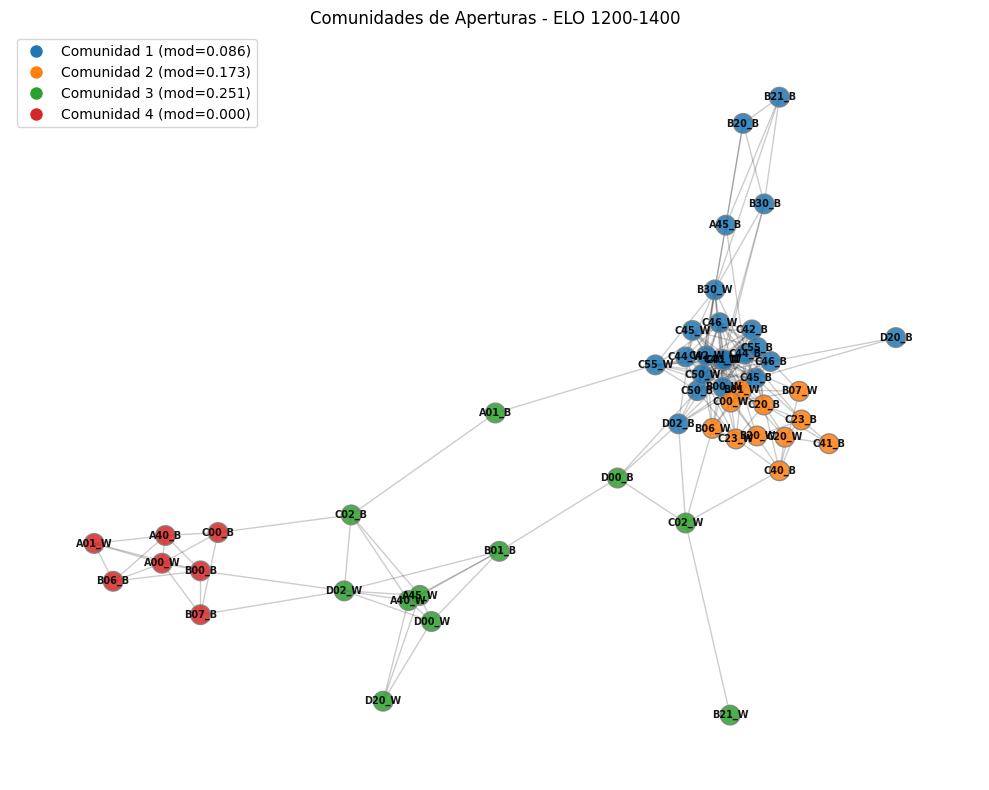


=== MÉTRICAS DE CADA COMUNIDAD ===

>>> Comunidad 1 (n=22):
Nodos principales: ['B20_B', 'C55_W', 'C46_W', 'C45_B', 'B00_W']

>>> Comunidad 2 (n=11):
Nodos principales: ['B01_W', 'C00_W', 'C20_W', 'C20_B', 'C41_B']

>>> Comunidad 3 (n=11):
Nodos principales: ['A01_B', 'D20_W', 'D00_W', 'C02_B', 'C02_W']

>>> Comunidad 4 (n=7):
Nodos principales: ['A01_W', 'A00_W', 'A40_B', 'C00_B', 'B06_B']

=== TABLA CONSOLIDADA DE MÉTRICAS POR COMUNIDAD ===
                         Comunidad 1  Comunidad 2  Comunidad 3  Comunidad 4
n_nodos                      22.0000      11.0000      11.0000       7.0000
n_aristas                   110.0000      31.0000      20.0000      15.0000
densidad_ponderada            0.0655       0.1271       0.0609       0.1577
clustering_ponderado          0.1820       0.2875       0.1321       0.3018
modularidad_ponderada         0.0854       0.1732       0.2515       0.0000
transitividad_ponderada       0.7598       0.6176       0.6941       0.7150
asortatividad_ponder

In [ ]:
tabla_consolidada_1200_1400, dicc_comunidades_1200_1400= analizar_coocurrencia_relevante(G_mayor_1200_1400, '1200-1400')


=== ANÁLISIS DE COOCURRENCIA - ELO 1400-1600 ===

=== FAMILIAS DE APERTURAS ===
Modularidad global: 0.308
Número total de comunidades: 3

--- Modularidad de cada comunidad ---

Familia 1:
  Tamaño: 26
  Miembros: ['A45_B', 'B20_B', 'B10_B', 'A00_W', 'A00_B', 'B21_B', 'C00_B', 'D00_W', 'C02_B', 'B01_B']...
  Cohesión: 0.240
  Modularidad (ponderada): 0.448

Familia 2:
  Tamaño: 24
  Miembros: ['A01_B', 'C20_B', 'C41_B', 'B07_W', 'C34_B', 'C46_W', 'C44_B', 'D00_B', 'C45_B', 'B00_W']...
  Cohesión: 0.366
  Modularidad (ponderada): 0.235

Familia 3:
  Tamaño: 16
  Miembros: ['C40_W', 'C00_W', 'C55_W', 'B40_W', 'C44_W', 'B10_W', 'C42_W', 'C62_W', 'C45_W', 'C50_W']...
  Cohesión: 0.542
  Modularidad (ponderada): 0.046


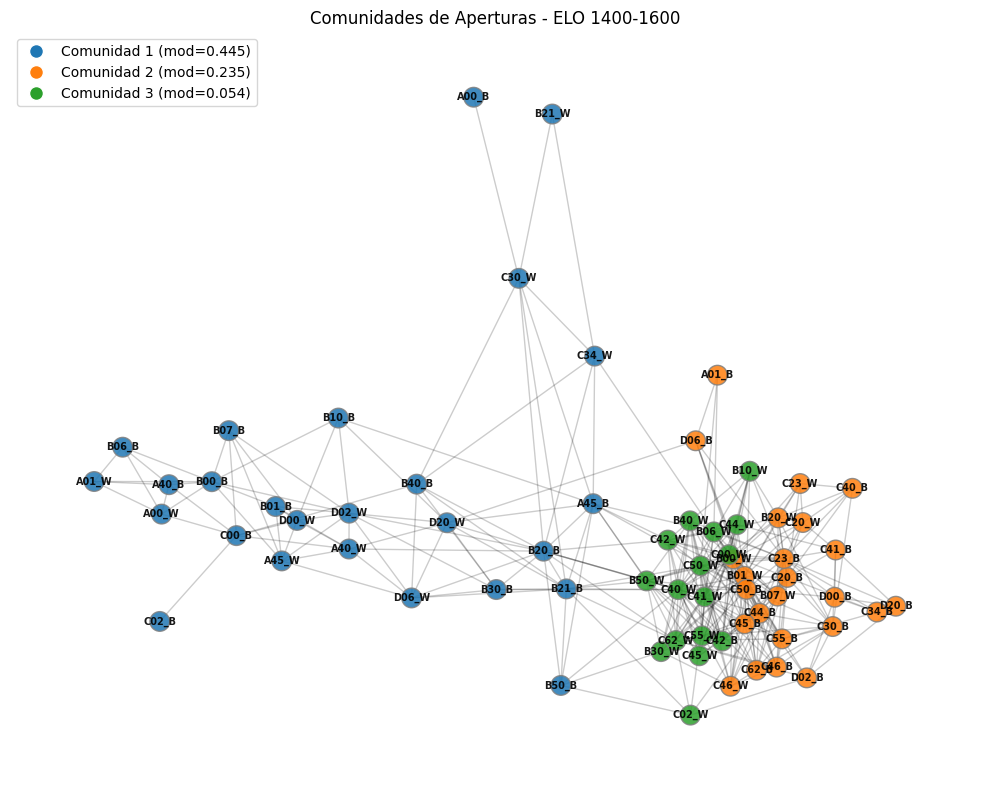


=== MÉTRICAS DE CADA COMUNIDAD ===

>>> Comunidad 1 (n=26):
Nodos principales: ['B20_B', 'B10_B', 'C00_B', 'B01_B', 'B40_B']

>>> Comunidad 2 (n=24):
Nodos principales: ['A01_B', 'C34_B', 'C46_W', 'D00_B', 'C45_B']

>>> Comunidad 3 (n=16):
Nodos principales: ['C40_W', 'C00_W', 'C55_W', 'C44_W', 'B40_W']

=== TABLA CONSOLIDADA DE MÉTRICAS POR COMUNIDAD ===
                         Comunidad 1  Comunidad 2  Comunidad 3
n_nodos                      26.0000      24.0000      16.0000
n_aristas                    78.0000     101.0000      65.0000
densidad_ponderada            0.0269       0.0549       0.0577
clustering_ponderado          0.1194       0.1638       0.1283
modularidad_ponderada         0.4450       0.2347       0.0462
transitividad_ponderada       0.5223       0.5511       0.6890
asortatividad_ponderada       0.1403      -0.1415      -0.1095


In [ ]:
tabla_consolidada_1400_1600, dicc_comunidades_1400_1600 = analizar_coocurrencia_relevante(G_mayor_1400_1600, '1400-1600')

=== ANÁLISIS DE COOCURRENCIA - ELO 1600-1800 ===

=== FAMILIAS DE APERTURAS ===
Modularidad global: 0.444
Número total de comunidades: 5

--- Modularidad de cada comunidad ---

Familia 1:
  Tamaño: 26
  Miembros: ['B10_B', 'A00_B', 'A00_W', 'A43_W', 'C00_B', 'D00_W', 'B01_B', 'A04_B', 'D30_W', 'B40_B']...
  Cohesión: 0.231
  Modularidad (ponderada): 0.449

Familia 2:
  Tamaño: 25
  Miembros: ['C40_W', 'C00_W', 'C55_W', 'B40_W', 'A01_B', 'C62_W', 'C50_W', 'C30_W', 'C44_B', 'C34_W']...
  Cohesión: 0.373
  Modularidad (ponderada): 0.170

Familia 3:
  Tamaño: 18
  Miembros: ['C20_B', 'C41_B', 'C34_B', 'D00_B', 'C45_B', 'D02_B', 'C30_B', 'C20_W', 'C21_B', 'D20_B']...
  Cohesión: 0.451
  Modularidad (ponderada): 0.195

Familia 4:
  Tamaño: 9
  Miembros: ['A45_B', 'B20_B', 'A43_B', 'B21_B', 'A02_W', 'B32_B', 'B30_B', 'B22_B', 'B50_B']...
  Cohesión: 0.667
  Modularidad (ponderada): 0.011

Familia 5:
  Tamaño: 6
  Miembros: ['B12_W', 'C21_W', 'C01_W', 'B22_W', 'C02_B', 'C02_W']...
  Cohesión: 

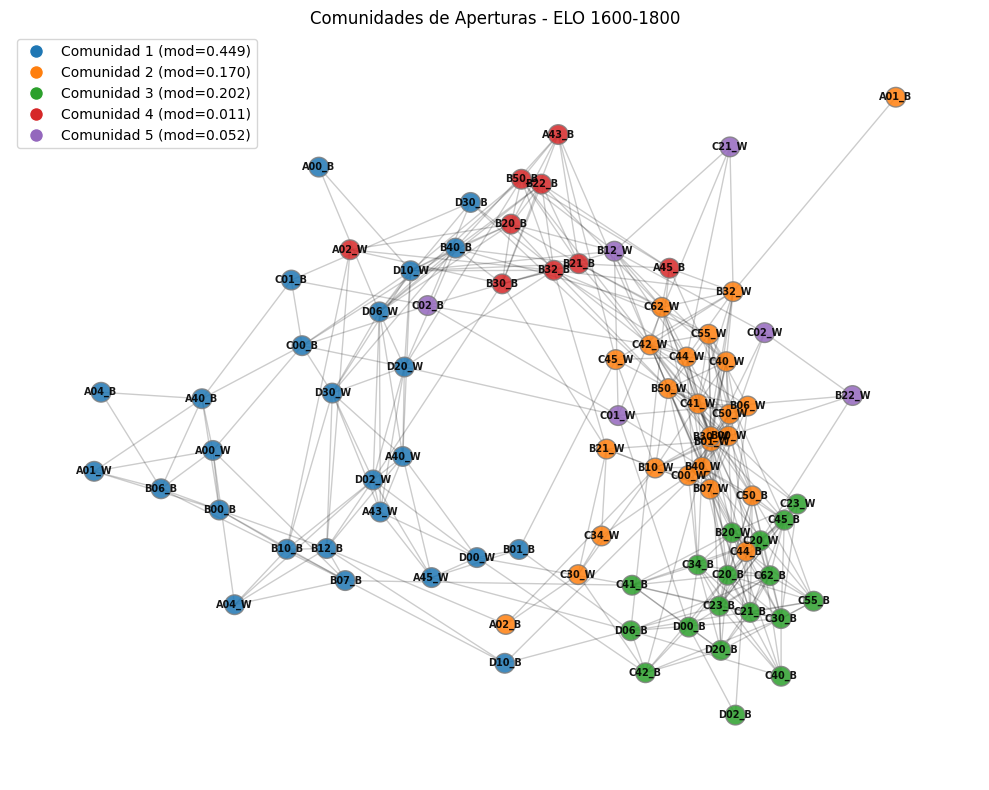


=== MÉTRICAS DE CADA COMUNIDAD ===

>>> Comunidad 1 (n=26):
Nodos principales: ['B10_B', 'C00_B', 'B01_B', 'B40_B', 'A04_W']

>>> Comunidad 2 (n=25):
Nodos principales: ['C55_W', 'A01_B', 'C34_W', 'B00_W', 'B50_W']

>>> Comunidad 3 (n=18):
Nodos principales: ['C30_B', 'C20_W', 'C21_B', 'C20_B', 'C41_B']

>>> Comunidad 4 (n=9):
Nodos principales: ['A45_B', 'B20_B', 'A43_B', 'B21_B', 'A02_W']

>>> Comunidad 5 (n=6):
Nodos principales: ['B12_W', 'C21_W', 'C01_W', 'C02_B', 'C02_W']

=== TABLA CONSOLIDADA DE MÉTRICAS POR COMUNIDAD ===
                         Comunidad 1  Comunidad 2  Comunidad 3  Comunidad 4  \
n_nodos                      26.0000      25.0000      18.0000       9.0000   
n_aristas                    75.0000     112.0000      69.0000      24.0000   
densidad_ponderada            0.0328       0.0397       0.0571       0.1051   
clustering_ponderado          0.1737       0.1142       0.1373       0.2192   
modularidad_ponderada         0.4333       0.1702       0.2019      

In [ ]:
tabla_consolidada_1600_1800, dicc_comunidades_1600_1800 = analizar_coocurrencia_relevante(G_mayor_1600_1800, '1600-1800')

## Subcomunidades dentro de la red 1400_1600

In [ ]:
def obtener_comunidad_especifica(diccionario_comunidades, numero_comunidad):
    clave = f'Comunidad {numero_comunidad}'
    if clave not in diccionario_comunidades:
        print(f"Error: {clave} no encontrada en el diccionario.")
        return None

    nodos = diccionario_comunidades[clave]
    print(f"=== {clave} ===")
    print(f"Tamaño: {len(nodos)} nodos")
    print(f"Nodos: {nodos}")

    return {
        'numero': numero_comunidad,
        'nodos': list(nodos),
        'tamaño': len(nodos)
    }

In [ ]:
comunidad_1 = obtener_comunidad_especifica(dicc_comunidades_1400_1600, numero_comunidad=1)

=== Comunidad 1 ===
Tamaño: 26 nodos
Nodos: ['A45_B', 'B20_B', 'B10_B', 'A00_W', 'A00_B', 'B21_B', 'C00_B', 'D00_W', 'C02_B', 'B01_B', 'B40_B', 'C30_W', 'B07_B', 'C34_W', 'B00_B', 'B30_B', 'A45_W', 'D20_W', 'A01_W', 'A40_B', 'B06_B', 'A40_W', 'D02_W', 'D06_W', 'B21_W', 'B50_B']


In [ ]:
G_mayor_1400_1600_comunidad_1 = G_mayor_1400_1600.subgraph(comunidad_1['nodos']).copy()

=== ANÁLISIS DE COOCURRENCIA - ELO 1400-1600 Comunidad_1 ===

=== FAMILIAS DE APERTURAS ===
Modularidad global: 0.415
Número total de comunidades: 3

--- Modularidad de cada comunidad ---

Familia 1:
  Tamaño: 12
  Miembros: ['B20_B', 'A45_B', 'A00_B', 'B21_B', 'B40_B', 'C30_W', 'D06_W', 'C34_W', 'B21_W', 'B30_B']...
  Cohesión: 0.470
  Modularidad (ponderada): 0.262

Familia 2:
  Tamaño: 9
  Miembros: ['B10_B', 'C00_B', 'D00_W', 'C02_B', 'D02_W', 'B01_B', 'A40_W', 'B07_B', 'A45_W']...
  Cohesión: 0.528
  Modularidad (ponderada): 0.120

Familia 3:
  Tamaño: 5
  Miembros: ['A01_W', 'A00_W', 'A40_B', 'B00_B', 'B06_B']...
  Cohesión: 1.000
  Modularidad (ponderada): 0.000


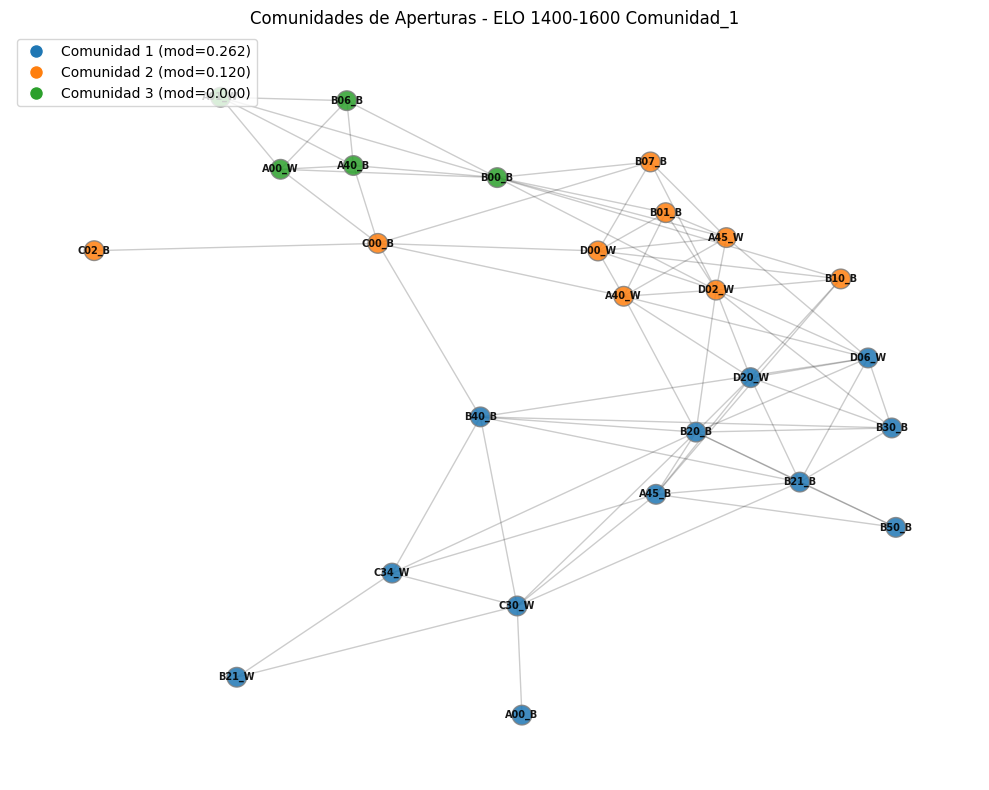


=== MÉTRICAS DE CADA COMUNIDAD ===

>>> Comunidad 1 (n=12):
Nodos principales: ['B20_B', 'A45_B', 'A00_B', 'B21_B', 'B40_B']

>>> Comunidad 2 (n=9):
Nodos principales: ['B10_B', 'C00_B', 'D00_W', 'D02_W', 'C02_B']

>>> Comunidad 3 (n=5):
Nodos principales: ['A01_W', 'A00_W', 'A40_B', 'B06_B', 'B00_B']

=== TABLA CONSOLIDADA DE MÉTRICAS POR COMUNIDAD ===
                         Comunidad 1  Comunidad 2  Comunidad 3
n_nodos                      12.0000       9.0000       5.0000
n_aristas                    31.0000      19.0000      10.0000
densidad_ponderada            0.0754       0.0857       0.2392
clustering_ponderado          0.2061       0.1823       0.4335
modularidad_ponderada         0.2617       0.1204       0.0000
transitividad_ponderada       0.6507       0.6743       1.0000
asortatividad_ponderada      -0.2152      -0.1794      -0.2500


In [ ]:
Com_1_1400_1600, dicc_comunidades_Com_1_1400_1600= analizar_coocurrencia_relevante(G_mayor_1400_1600_comunidad_1, '1400-1600 Comunidad_1')